# Machine Learning Engineer Nanodegree
## Supervised Learning
## Project: Finding Donors for *CharityML*

## Getting Started

This project on modeling individuals' income used data collected from the 1994 U.S. Census. The goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. The article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data investigated here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

----
## Exploring the Data


In [2]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.head(n=1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


### Implementation: Data Exploration



In [3]:
# Total number of records
n_records = len(data)

# Number of records where individual's income is more than $50,000
n_greater_50k = len(data[data['income']=='>50K'])

# Number of records where individual's income is at most $50,000
n_at_most_50k = len(data[data['income']=='<=50K'])

# Percentage of individuals whose income is more than $50,000
greater_percent = round(n_greater_50k / (n_greater_50k + n_at_most_50k)*100, 2)

# Print the results
print("Total number of records: {}".format(n_records))
print("Individuals making more than $50,000: {}".format(n_greater_50k))
print("Individuals making at most $50,000: {}".format(n_at_most_50k))
print("Percentage of individuals making more than $50,000: {}%".format(greater_percent))

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78%


** Featureset Exploration **

* **age**: continuous. 
* **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 
* **education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 
* **education-num**: continuous. 
* **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 
* **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 
* **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 
* **race**: Black, White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other. 
* **sex**: Female, Male. 
* **capital-gain**: continuous. 
* **capital-loss**: continuous. 
* **hours-per-week**: continuous. 
* **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

----
## Preparing the Data


### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 



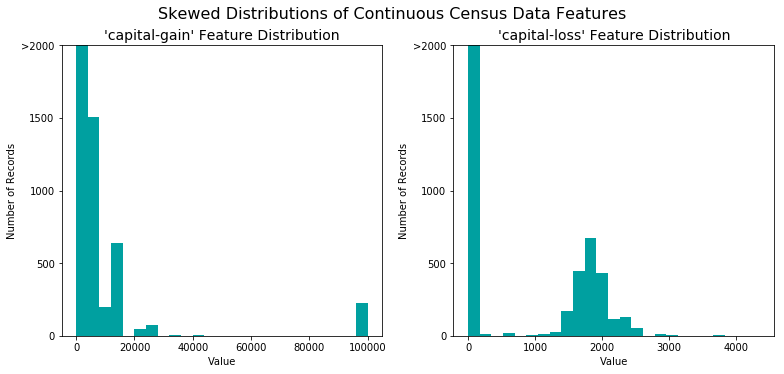

In [4]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.



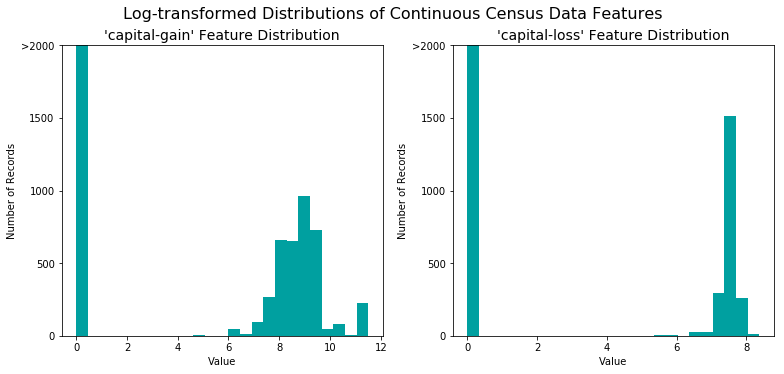

In [5]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_log_transformed, transformed = True)

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. 



In [6]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

# Show an example of a record with scaling applied
display(features_log_minmax_transform.head(n = 5))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba


### Implementation: Data Preprocessing



In [7]:
# One-hot encode the 'features_log_minmax_transform' data using pandas.get_dummies()
features_final = pd.get_dummies(features_log_minmax_transform)

# Encode the 'income_raw' data to numerical values
income = (income_raw == ">50K").astype(np.uint8)

# Print the number of features after one-hot encoding
encoded = list(features_final.columns)
print ("{} total features after one-hot encoding.".format(len(encoded)))


#print (encoded)

103 total features after one-hot encoding.


### Shuffle and Split Data
 80% of the data will be used for training and 20% for testing.



In [9]:
# Import train_test_split
from sklearn.cross_validation import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    income, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 36177 samples.
Testing set has 9045 samples.


C:\Users\chanh\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


----
## Evaluating Model Performance


### Metrics and the Naive Predictor
*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes (those who make at most \$50,000, and those who make more), it's clear most individuals do not make more than \$50,000. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than \$50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for the data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, *CharityML* would identify no one as donors. 


#### Note: accuracy, precision, recall

** Accuracy ** measures how often the classifier makes the correct prediction. It’s the ratio of the number of correct predictions to the total number of predictions (the number of test data points).

** Precision ** tells us what proportion of messages we classified as spam, actually were spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all positives(all words classified as spam, irrespective of whether that was the correct classificatio), in other words it is the ratio of

`[True Positives/(True Positives + False Positives)]`

** Recall(sensitivity)** tells us what proportion of messages that actually were spam were classified by us as spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all the words that were actually spam, in other words it is the ratio of

`[True Positives/(True Positives + False Negatives)]`

For classification problems that are skewed in their classification distributions like in our case, for example if we had a 100 text messages and only 2 were spam and the rest 98 weren't, accuracy by itself is not a very good metric. We could classify 90 messages as not spam(including the 2 that were spam but we classify them as not spam, hence they would be false negatives) and 10 as spam(all 10 false positives) and still get a reasonably good accuracy score. For such cases, precision and recall come in very handy. These two metrics can be combined to get the F1 score, which is weighted average(harmonic mean) of the precision and recall scores. This score can range from 0 to 1, with 1 being the best possible F1 score(we take the harmonic mean as we are dealing with ratios).

### Question 1 - Naive Predictor Performace


In [10]:
income_pred=income.apply(lambda x:1)

TP=sum(map(lambda x,y: 1 if x==1 and y==1 else 0, income,income_pred)) #True Pos
FP=sum(map(lambda x,y: 1 if x==0 and y==1 else 0, income,income_pred)) #False Pos
FN=sum(map(lambda x,y: 1 if x==1 and y==0 else 0, income,income_pred)) #False Neg

# accuracy = TP/(TP+FP)
accuracy = float(TP)/(TP+FP)

# The commented code below was used to confirm the precision calculation was correct
#accuracy1 = accuracy_score(income,income_pred)
#print 'accuracy comparison',accuracy,accuracy1

# recall = TP/(TP+FN)
recall=float(TP)/(TP+FN)

# The commented code below was used to confirm the recall calculation was correct
#recal1=recall_score(income,income_pred)
#print 'recall comparison',recal1,recall1

# Calculate F-score using the formula above for beta = 0.5
beta=0.5
fscore = (1+beta**2)*(accuracy*recall)/(beta**2*accuracy+recall)
# Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))


Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


###  Supervised Learning Models
**The following are some of the supervised learning models that are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that you may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent Classifier (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Question 2 - Model Application
List three of the supervised learning models above that are appropriate for this problem that you will test on the census data. For each model chosen

- Describe one real-world application in industry where the model can be applied. 
- What are the strengths of the model; when does it perform well?
- What are the weaknesses of the model; when does it perform poorly?
- What makes this model a good candidate for the problem, given what you know about the data?



**Answer: **

- Three models were selected to test out predicting the data, including Gaussian Naive Bayes, Support Vector Machines, and Ensemble Method (AdaBoost).


**Ensemble Method:AdaBoost**

- AdaBoost is a powerful classifier which works well on both basic and more complex recognition problems. It can be used in various fields like biology, computer vision, and speech proecssing. A real-world application in industry using AdaBoost is Face Detection/Facial Recognition.

- The strengths of AdaBoost include: 1) requires tuning of fewer parameters, 2) simple to implement, 3) implicit feature selection, 4) provably effective given weak learning assumption, 5) performs very well in practice, and 6) produces fairly good generalization. When there is low noise and few outliers, AdaBoost performs well. 

- The weaknesses of AdaBoost include: 1) suboptimal solution, 2) sensitive to noisy data and outliers, 3) weak classifiers too complex could lead to overfitting, 4) weak classifiers too weak can lead to low margins and overfitting. Therefore, when there are noises or outliers, or weak learners being too complex, or weak learners being too weak can lead to poor performance of AdaBoost. 

- AdaBoost uses a combination of multiple weak learners, which then turns into a stronger learner. Since the goal is to classify who would more likely be a donor and there are many features in this dataset, using AdaBoost can be a simple solution because of its implicit feature selection. 


**Gaussian Naive Bayes**

- Naive Bayes is a collection of classification algorithms based on Bayes Theorem. The principle is that every feature being classified is independent of the value of any other feature. However, features aren't always independent which is often seen as a shortcoming of the Naive Bayes algorithm and the reason why it is called 'naive'. Gaussian Naive Bayes is specifically used when the features have continuous values. It is also assumed that all the features are following a gaussian distribution (i.e., normal distribution). Its real-world application examples include: classify emails as spam or ham, classify emails promise an attachment, and classify which web pages are student home pages.  (source1: Aylien's blog, http://blog.aylien.com/naive-bayes-for-dummies-a-simple-explanation/), source2: dataaspirant.com, http://dataaspirant.com/2017/02/20/gaussian-naive-bayes-classifier-implementation-python/)

- Advantages of Gaussian Naive Bayes: 1) simple to understand and implement, 2) easy to train, 3) computationally fast, 4) works well with high dimensions. It performs well when all features are continuous. 

- Disadvantage of Gaussian Naive Bayes: relies on independence assumption. Gaussian Naive Bayes will perform badly if this independence assumption is not met. 

- All features of the data in this project are categorical. Therefore it is chosen to make predictions. 


**Support Vector Machines**

- A support vector machine (SVM) is a supervised machine learning algorithm that can be employed for both classification and regression purposes. SVMs are more commonly used in classfication problems. SVMs are based on the idea of finding a hyperplane that best divides a dataset into two classes. Its real-world application examples include: face detection, text and hypertext categorization, classification of images, bioinformatics, sentiment analysis, handwriting recognition and generalized predictive control. (source1: KDnuggets, https://www.kdnuggets.com/2016/07/support-vector-machines-simple-explanation.html, source2: data-flair, https://data-flair.training/blogs/applications-of-svm/)

- Advantages of SVMs: 1) performs similarly to logistic regression when linear separation, 2) performs well with non-linear boundary depending on the kernel used, 3) handles high dimensional data well, 4) it produces high accuracy predictions, 5) works well on smaller cleaner datasets, 6) efficient due to the usage of a subset of training points. When a dataset is clean and relatively small, SVMs can perform well. (source1: https://github.com/ctufts/Cheat_Sheets/wiki/Classification-Model-Pros-and-Cons, source2: KDnuggets, https://www.kdnuggets.com/2016/07/support-vector-machines-simple-explanation.html)
 
- Disadvantages: 1) is not suited to larger datasets as the training time with SVMs can be high, 2) less effective on noisier datasets with overlapping classes, and 3) susceptible to overfitting/training issues depending on kernel. So when a dataset has such aforementioned issues, SVMs would not perform well on it. 

- Although this dataset is large, SVM can still be considered as a good candidate for making predictions because the features in this dataset do not seem to overlap and could have a clear boundary to determine the income level. 

### Implementation - Creating a Training and Predicting Pipeline


In [11]:
# Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import fbeta_score 
from sklearn.metrics import accuracy_score
def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    # Calculate the training time
    results['train_time'] = end - start
        
    # Get the predictions on the test set(X_test),
    #       then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end - start
            
    # Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    # Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # Compute F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, beta=0.5)
        
    # Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test, predictions_test, beta=0.5)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

### Implementation: Initial Model Evaluation


GaussianNB trained on 361 samples.
GaussianNB trained on 3617 samples.
GaussianNB trained on 36177 samples.


C:\Users\chanh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


SVC trained on 361 samples.
SVC trained on 3617 samples.
SVC trained on 36177 samples.
AdaBoostClassifier trained on 361 samples.
AdaBoostClassifier trained on 3617 samples.
AdaBoostClassifier trained on 36177 samples.


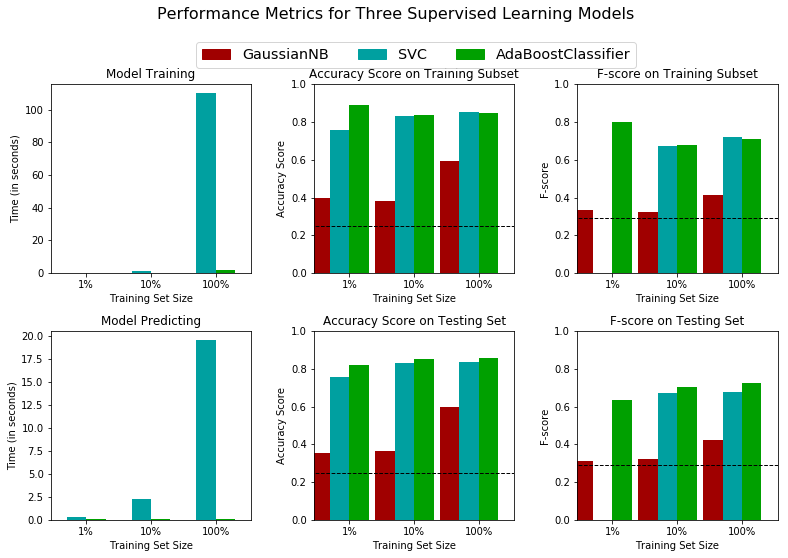

In [12]:
# Import the three supervised learning models from sklearn
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier

# Initialize the three models
clf_A = GaussianNB()
clf_B = SVC(random_state=0)
clf_C = AdaBoostClassifier(random_state=0)

#Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_1 = int(len(X_train)*0.01)
samples_10 = int(len(X_train)*0.1)
samples_100 = len(X_train)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

----
## Improving Results


### Question 3 - Choosing the Best Model



**Answer: **
<br\>
From the result above, AdaBoost seems to be the most appropriate model for the task of identifying individuals that make more than $50K. Compared to AdaBoost and Support Vector Machine, Gaussian Naive Bayes did not do a good job at achieving a high accuracy during training and testing. As well, Gaussian Naive Bayes only achieved a f-score lower than 0.5 during both training and testing. Therefore, Gaussian Naive Bayes was not chosen to complete this task of finding a donor. Although both AdaBoost and Support Vector Machine have similar accuracty score, AdaBoost has slightly higher f-score. F-score is a measure that combines precision and recall, which is the harmonic mean of precision and recall. Depending on the task, f-score could be used as a reference for selecting an appropriate model. In the case of finding donors, precision is more important than recall. That suggests that a model with a f-score closer to 1 is a better fit for the task. This means that AdaBoost tends to produce a more precise prediction. In addition, given that not all features of this dataset are independent, Gaussian Naive Bayes may not be a suitable model. 

<br\> 
With all the attributes considered, I feel that AdaBoost would be the most appropriate model for completing this task. 

### Question 4 - Describing the Model in Layman's Terms

* In one to two paragraphs, explain to *CharityML*, in layman's terms, how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical jargon, such as describing equations.



**Answer: ** 
<br\>
Adaboost is a boosting type ensemble learner. This method works by combining multiple individual "weak" learning hypotheses to create one strong model. Each weak hypothesis used is better at classifying the data than random chance. However, it's the combination of all of these independent weak learning hypotheses what makes the model more capable of predicting accurately on unseen data than each of the individual hypothesis would. 

A weak learner is any machine learning algorithm that gives better accuracy than simply guessing. For instance, if you are trying to classify animals at a zoo, you might have an algorithm that can correctly identify zebras most of the time, but it simply guesses for any other animal. That algorithm would be a weak learner because it is better than guessing.

If you had an algorithm that identified every animal as a zebra, then that probably is not better than guessing and so it would not be a weak learner.

For boosting problems, the best kinds of weak learners are ones that are very accurate, even if it is only over a limited scope of the problem. For instance the algorithm that correctly identifies zebras would be good. It allows you to confidently identify as least most of the zebras, allowing other weak learners to focus on the remaining animals. Boosting algorithms typically work by solving subsections of the problem, by peeling them away so future boosting iterations can solve the remaining sections.

Imagine you are hiring people to build your house, and you have 10 different big jobs that need to be done. A great way of doing it would be to get someone who is really good at foundations to build the foundation. Then hire a very good carpenter to focus on the framing. Then hire a great roofer and plumber to focus stage, a small subsection of the project is getting completely solved.

The takeaway is that weak learners are best combined in a way that allows each one to solve a limited section of the problem. Any machine learning routine can be used as a weak learner. Neural nets, support vector machines or any other would work, but the most commonly used weak learner is the decision tree.

So how exactly does boosting work in this method? The way boosting works to build a stronger classifier is through building a first model with the training data. Then build a second model to correct the error generates by the first model. This process repeats which results in more models being built until it predicts the training data perfectly or until it reaches the maximum number of models added. For example, you wish to use the US Census data to predict people's income. Then first you would need to separate the data into two parts, including 80% of which being the training set and 20% being the testing data set. Why do you need to do that? It is because that you would want to first train the model then being able to test how well your model performs in prediction. Next, you will show your first model the training data. You will get an error rate after it finishes predicting the training data. Then, you will build a second model which can then correct the errors made by the first model and trying to increase the number of results being correctly predicted. This process repeats until you get to a perfect prediction score or the most number of models you can add. This is how you boost the model. 

### Implementation: Model Tuning


In [14]:
# Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import fbeta_score
from sklearn.ensemble import AdaBoostClassifier
import warnings
warnings.filterwarnings('always')
# Initialize the classifier
clf = AdaBoostClassifier(random_state = 0)

# Create the parameters list you wish to tune, using a dictionary if needed.
# parameters = {'parameter_1': [value1, value2], 'parameter_2': [value1, value2]}
parameters = {'n_estimators':[80, 250, 500], 'learning_rate':[1.0, 1.5, 2.5]}

# Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta = 0.5)

# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, param_grid = parameters, scoring = scorer)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

Unoptimized model
------
Accuracy score on testing data: 0.8576
F-score on testing data: 0.7246

Optimized Model
------
Final accuracy score on the testing data: 0.8677
Final F-score on the testing data: 0.7452


### Question 5 - Final Model Evaluation

* What is your optimized model's accuracy and F-score on the testing data? 
* Are these scores better or worse than the unoptimized model? 
* How do the results from your optimized model compare to the naive predictor benchmarks you found earlier in **Question 1**?_  



#### Results:

|     Metric     | Unoptimized Model | Optimized Model |
| :------------: | :---------------: | :-------------: | 
| Accuracy Score |       0.8576      |     0.8677      |
| F-score        |       0.7246      |   0.7452        |


**Answer: **
<br\>
- The optimized model's accuracy score is 0.8677 and the F-score is 0.7452.
<br\>
- These scores are better than the unoptimized model. 
<br\>
- When compared to the naive predictor benchmarks found in Question 1, these results of the optimized model are significantly better and higher. 

----
## Feature Importance



### Question 6 - Feature Relevance Observation
When **Exploring the Data**, it was shown there are thirteen available features for each individual on record in the census data. Of these thirteen records, which five features do you believe to be most important for prediction, and in what order would you rank them and why?

**Answer:**
1. Capital Gain: If one has more capital gain, this person will be more likely to donate. 

2. Occupation: The income of a person directly affect whether or not a person would donate. One's occupation can give a pretty clear idea as to how much salary this person makes. Therefore I rank 'Occupation' as the number one feature. 

3. Capital loss: If one has more capital loss, I don't think this person will be likely to donate. 

4. Relationship Status: If one is married and has children, maybe he or she would not be as likely to donate due to the future investment and spending on their children. 

5. Education: I feel that one with higher education may be more likely to have a higher paying job, which could suggest that the person would be more likely to donate. 



### Implementation - Extracting Feature Importance


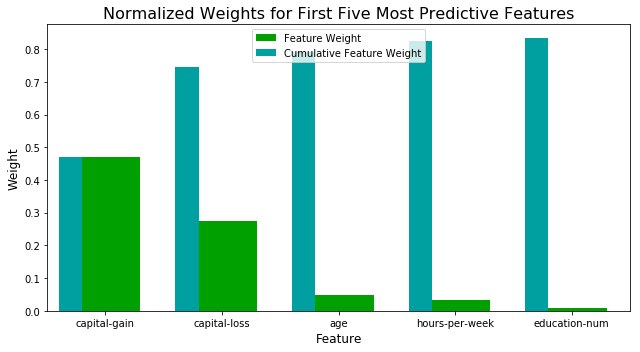

In [15]:
# Import a supervised learning model that has 'feature_importances_'
from sklearn.ensemble import ExtraTreesClassifier

# Train the supervised model on the training set using .fit(X_train, y_train)
model = AdaBoostClassifier(random_state=0,n_estimators=500).fit(X_train, y_train)


# Extract the feature importances using .feature_importances_ 
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

### Question 7 - Extracting Feature Importance

Observe the visualization created above which displays the five most relevant features for predicting if an individual makes at most or above \$50,000.  
* How do these five features compare to the five features you discussed in **Question 6**?
* If you were close to the same answer, how does this visualization confirm your thoughts? 
* If you were not close, why do you think these features are more relevant?

**Answer:**
<br\>
- My opions on the top five important features are not completely align with the assessement results above. I only got capital gain, capital loss and education right. 

- From the bar chart above, capital gain has the heaviest feature weight, followed by capital loss, age, hours-per-week, and education. In my answers to Question 6, I ranked capital gain as number one, capital loss as number three, and education as number five. The ranking was pretty closed to the assessment result. 

- I did not think about the number of hours one works per week would have an impact on the decision to donation. This took me by suprise. Because I think occupation and work-class may be better features to predict the income of a person, but it does make senese at a certain level that if paid at the same rate, one works more hours per week will have more income. As far as age, I did not think it would play a role. But I can also understand that younger people may not have as high income as older people given their years of experience. 

### Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. The code cell below will use the same optimized model you found earlier, and train it on the same training set *with only the top five important features*. 

In [16]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

Final Model trained on full data
------
Accuracy on testing data: 0.8677
F-score on testing data: 0.7452

Final Model trained on reduced data
------
Accuracy on testing data: 0.8421
F-score on testing data: 0.7003


### Question 8 - Effects of Feature Selection

* How does the final model's F-score and accuracy score on the reduced data using only five features compare to those same scores when all features are used?
* If training time was a factor, would you consider using the reduced data as your training set?

**Answer:**
<br\>
- The final model's F-score and accuracy score are lower than those of the previous model. This makes sense because the five selected features did not provide the full picture of the dataset. Because other than these five features, there are other factors that could affect the likelihood of someone's decision on donation. 

- If training time was a factor, I would consider using the reduced data as my training set because although the F-score and accuracy score were lower, they were not that significantly low. The small increase in classification error could be an appropriate tradeoff in that case. 